# Sobol Indices

*Sobol's method* is one of the most popular for global sensitivity analysis. It builds on the [ANOVA decomposition](https://github.com/rballester/tntorch/blob/master/tutorials/anova.ipynb).

In [16]:
import tntorch as tn
import torch

N = 10
t = tn.rand([32]*N, ranks_tt=5)
t

10D TT tensor:

 32  32  32  32  32  32  32  32  32  32
  |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   5   5   5   5   5   5   5   5   5   1

With *tntorch* we can handle all Sobol indices (i.e. for all subsets $\alpha \subseteq \{0, \dots, N-1\}$) at once. We can access and aggregate them using the function `sobol()` with the appropriate mask.

### Single Variables

The effect attributable to one variable only (without interactions with others) is known as its *variance component*. Let's compute it for the first variable $x$:

In [17]:
x, y, z = tn.symbols(N)[:3]
tn.sobol(t, mask=tn.only(x))

tensor(0.2034)

(see [this notebook](https://github.com/rballester/tntorch/blob/master/tutorials/logic.ipynb) for more on symbols and masks)

Input parameters $x, y, \dots$ need to be independently distributed. By default, uniform marginal distributions are assumed, but you can specify others with the `marginals` argument (list of vectors). For instance, if the first variable can only take one value, then its sensitivity indices will be 0 (no matter how strong its effect on the multidimensional model is!):

In [18]:
marginals = [None]*N  # By default, None means uniform
marginals[0] = torch.zeros(32)
marginals[0][0] = 1  # The marginal PMF is ll zeros but the first value
tn.sobol(t, tn.only(x), marginals=marginals)

tensor(0.)

The effect that also includes $x$'s interaction with other variables is called *total Sobol index* (it's always larger than the variance component):

In [19]:
tn.sobol(t, x)

tensor(0.2685)

### Tuples of variables

What are the indices for the first and third variables $x$ and $z$?

In [20]:
tn.sobol(t, tn.only(x & z))  # Variance component

tensor(0.0031)

In [21]:
tn.sobol(t, x | z)  # Total index

tensor(0.3359)

For tuples of variables two additional kinds of indices exist. The *closed index* aggregates all components for tuples *included* in $\pmb{\alpha}$, and for tuple $\{x, z\}$ it can be computed as follows:

In [22]:
tn.sobol(t, tn.only(x | z))

tensor(0.2569)

The *superset index* aggregates all components for tuples *that include* $\pmb{\alpha}$:

In [23]:
tn.sobol(t, x & z)

tensor(0.0054)

We can also easily count the influence of all $k$-plets of variables combined:

In [24]:
tn.sobol(t, tn.weight_mask(N, weight=[1]))

tensor(0.8434)

Note that we'll get the same result if we combine the effects differently:

In [25]:
print(tn.sobol(t, x & ~z) + tn.sobol(t, ~x & z) + tn.sobol(t, x & z))
print(tn.sobol(t, x) + tn.sobol(t, z) - tn.sobol(t, x & z))

tensor(0.3359)
tensor(0.3359)


### The Mean Dimension

Variance components are the basis for an important advanced sensitivity metric, the *mean dimension*. It's defined as $D_S := \sum_{\alpha} |\pmb{\alpha}| \cdot S_{\alpha}$ and computed as:

In [26]:
tn.mean_dimension(t)

tensor(1.1770)

We can also compute it in one line by weighting the Sobol indices by their tuple weight (according to the definition of mean dimension):

In [27]:
tn.sobol(t, tn.weight(t.ndim))

tensor(1.1770)

The mean dimension is always greater or equal than 1. It gives a notion of *complexity* of a multidimensional function (the lower the mean dimension, the simpler it is). For example, rounding a tensor usually results in a lower mean dimension:

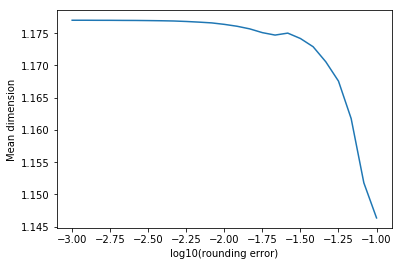

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

errors = 10**np.linspace(-1, -3, 25)
mean_dimensions = []
for eps in errors:
    mean_dimensions.append(tn.mean_dimension(tn.round(t, eps=eps)))
    
plt.figure()
plt.plot(np.log10(errors), mean_dimensions)
plt.xlabel('log10(rounding error)')
plt.ylabel('Mean dimension')
plt.show()

### The Dimension Distribution

Last, the dimension distribution gathers the relevance of $k$-tuples of variables for each $k = 1, \dots, N$:

In [29]:
tn.dimension_distribution(t)

tensor([8.4338e-01, 1.3813e-01, 1.6729e-02, 1.6211e-03, 1.3041e-04, 8.8621e-06,
        5.1081e-07, 2.4644e-08, 9.5344e-10, 2.7996e-11])

It can be viewed as a probability mass function, namely the probability of choosing a $k$-variable tuple, if tuples are chosen according to their variance components. The expected value of this random variable is the mean dimension. Naturally, the dimension distribution must sum to $1$:

In [30]:
sum(tn.dimension_distribution(t))

tensor(1.0000)